# Statistical physics of graphs and networks
## *Project:* study of the configuration model of random graphs
### *Master in physics of complex systems*
Joseph Touzet

We first import a few packages:

In [3]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt

We will use _networkx_ to manage and plot networks.

We also define the parameter for ploting networks:

In [4]:
options = {
    "font_size": 2,
    "node_size": 10,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 4,
    "width": 3,
}

### Problem 1: Generation of instances of the random graph model

First we will implement a few utility functions:

In [5]:
def choose_and_pop_from_list(items):
    index = random.randrange(len(items))
    return items.pop(index)

And then move on to the main asked functions:

In [61]:
def gen_rgm(N, pi):
    G = nx.Graph()
    for i in range(N):
        G.add_node(i)

    n_d1 = int(np.round(N*(1 - pi)/2)*2) # so that n_d1 + 4*n_d4 is pair
    n_d4 = N - n_d1

    stubs = []
    for i in range(n_d1):
        stubs.append(i)
    for i in range(n_d1, N):
        for j in range(4):
            stubs.append(i)
    
    while stubs:
        j = choose_and_pop_from_list(stubs)
        k = choose_and_pop_from_list(stubs)
        G.add_edge(j, k)
        G.add_edge(k, j)

    return G

def gen_rgm_biased(N, pi):
    G = nx.Graph()
    for i in range(N):
        G.add_node(i)

    n_d1 = int(np.round(N*(1 - pi)/2)*2) # so that n_d1 + 4*n_d4 is pair

    degree = {}
    for i in range(N):
        degree[i] = 1 if i < n_d1 else 4
    
    while len(degree) >= 2:
        unique_stubs = list(degree.keys())
        
        j = choose_and_pop_from_list(unique_stubs)
        while True:
            k = choose_and_pop_from_list(unique_stubs)
            if not G.has_edge(j, k):
                G.add_edge(j, k)
                G.add_edge(k, j)

                degree[j] -= 1
                if degree[j] == 0:
                    del degree[j]
                    
                degree[k] -= 1
                if degree[k] == 0:
                    del degree[k]

                break
            elif len(unique_stubs) == 0:
                del degree[j]
                break

    return G

Which we then test:

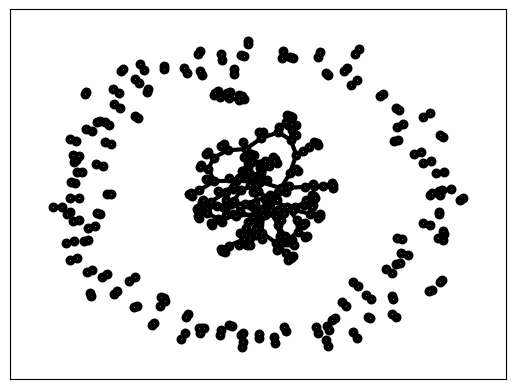

In [105]:
size, pi = 400, 0.2
graph = gen_rgm_biased(size, pi)

nx.draw_networkx(graph, **options)

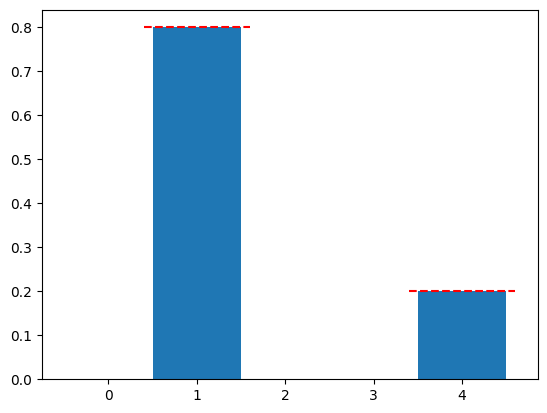

In [107]:
degree_list = [graph.degree[i] for i in range(len(graph))]

plt.hist(degree_list, density=True, bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
plt.plot([0.4, 1.6], [1-pi, 1-pi], 'r--')
plt.plot([3.4, 4.6], [pi,   pi],   'r--')
#plt.yscale('log')
plt.show()

## Problem 2: The giant component

We first need a function that (recursivly) walks through a graph to get the connected component starting from a given node:

In [85]:
def get_connected_component(graph, node, visited=None):
    if visited is None:
        visited = []
    visited.append(node)
    
    for neighbor in graph.neighbors(node):
        if neighbor not in visited:
            connected = get_connected_component(graph, neighbor, visited)
            
            for connected_node in connected:
                if connected_node not in visited:
                    visited.append(connected_node)
    return visited

We then use this function to efficently go through connected components (once per connected components), and return the largest connected components once there is not enough nodes to hope to find another even larger connected component:

In [86]:
def find_largest_connected_component(graph):
    n_nodes     = graph.number_of_nodes()
    not_visited = list(range(n_nodes))
    
    largest_connected_component = []
    while True:
        starting_node = not_visited[0]
        connected_component = get_connected_component(graph, starting_node)

        for node in connected_component:
            not_visited.remove(node)

        if len(connected_component) >= len(largest_connected_component):
            largest_connected_component = connected_component
            
        if len(not_visited) <= len(largest_connected_component):
            return largest_connected_component

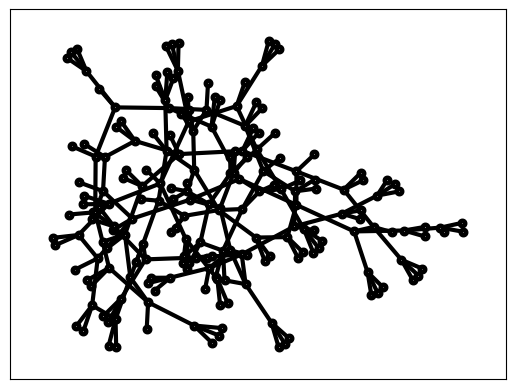

In [87]:
largest_connected_component = find_largest_connected_component(graph)
largest_connected_subgraph = graph.subgraph(largest_connected_component)

nx.draw_networkx(largest_connected_subgraph, **options)

(a) We can now plot the average proportion of nodes inside of the giant component versus the value of $\pi$:

In [88]:
N, size = 25, 300
pis = np.linspace(0, 1, 15)

avg_size = []
for pi in pis:
    avg_size.append(0)
    for n in range(N):
        graph = gen_rgm_biased(size, pi)
        largest_connected_component = find_largest_connected_component(graph)
        avg_size[-1] += len(largest_connected_component)
    avg_size[-1] /= N*size

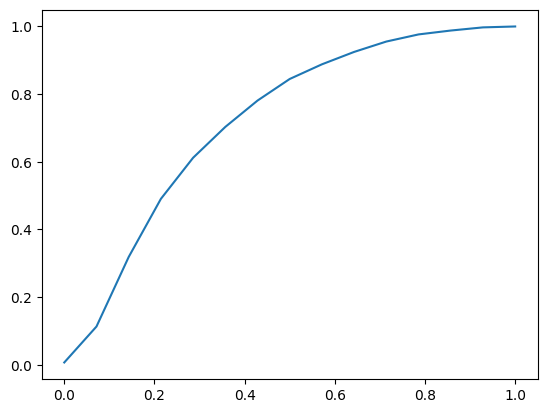

In [89]:
plt.plot(pis, avg_size)
plt.show()

(b) TODO

(c) TODO

### Problem 3: Emergence of the 3-core

In [90]:
def find_k_core(graph, k):
    def get_k_connected(graph, k, node, k_core=None):
        if graph.degree[node] < k:
            return k_core
        
        if k_core is None:
            k_core = []
        k_core.append(node)
        
        for neighbor in graph.neighbors(node):
            if graph.degree[neighbor] >= k:
                if neighbor not in k_core:
                    core = get_k_connected(graph, k, neighbor, k_core)
                        
                    for core_node in core:
                        if core_node not in k_core:
                            k_core.append(core_node)
                                
        return k_core
    
    n_nodes     = graph.number_of_nodes()
    not_visited = list(range(n_nodes))
    
    k_core = []
    while True:
        starting_node = not_visited[0]
        if graph.degree[starting_node] >= k:
            k_connected = get_k_connected(graph, k, starting_node)
        
            for node in k_connected:
                not_visited.remove(node)
        
            if len(k_connected) >= len(k_core):
                k_core = k_connected
        else:
            not_visited.remove(starting_node)
                
        if len(not_visited) <= len(k_core):
            return k_core

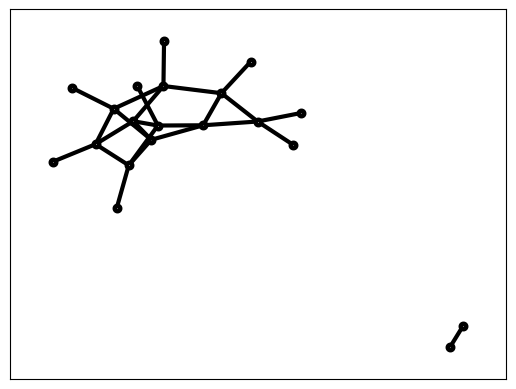

In [91]:
graph = gen_rgm_biased(20, 0.5)

nx.draw_networkx(graph, **options)

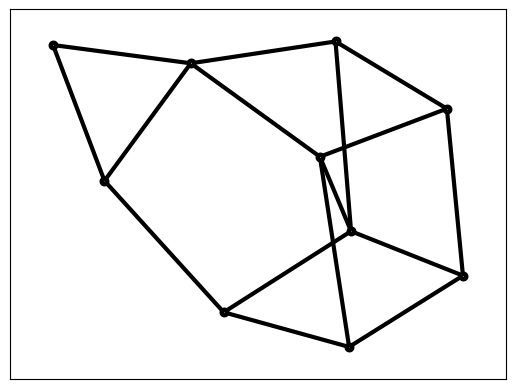

In [92]:
core3_component = find_k_core(graph, 3)
core3_subgraph = graph.subgraph(core3_component)

nx.draw_networkx(core3_subgraph, **options)

(a) We can now plot the average proportion of nodes inside of the giant component versus the value of $\pi$:

In [93]:
N, size = 25, 200
pis = np.linspace(0, 1, 15)

avg_size_3core = []
for pi in pis:
    avg_size_3core.append(0)
    for n in range(N):
        graph = gen_rgm_biased(size, pi)
        largest_connected_component = find_k_core(graph, 3)
        avg_size_3core[-1] += len(largest_connected_component)
    avg_size_3core[-1] /= N*size

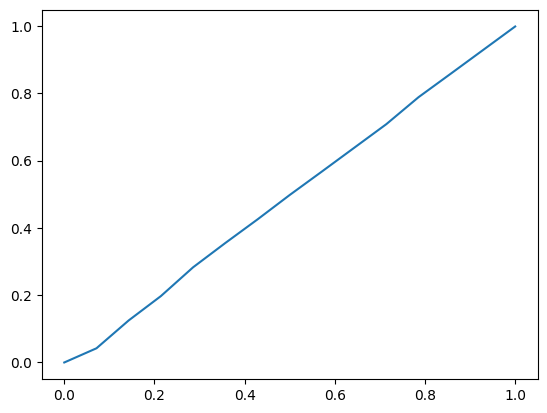

In [94]:
plt.plot(pis, avg_size_3core)
plt.show()

(b) TODO

(c) TODO

### Problem 4: The ferromagnetic Ising model

In [95]:
def gen_random_state(N_node, p=0.5):
    random_state = np.random.rand(N_node)
    state = 2*(random_state < p) - 1
    return state

def get_state_magnetisation(state):
    return np.mean(state)

In [96]:
def monte_carlo_simulate(graph, state, T, N_it_per_node):
    n_nodes = graph.number_of_nodes()
    
    for i in range(n_nodes*N_it_per_node):
        node = np.random.randint(0, n_nodes)
        
        total_surounding_spin = 0
        for neighbor in graph.neighbors(node):
            total_surounding_spin += state[neighbor]
        
        delta_E = 2*state[node]*total_surounding_spin
        if delta_E < 0:
            state[node] = -state[node]
        else:
            P_flip = np.exp(-delta_E/T)
            if np.random.rand() < P_flip:
                state[node] = -state[node]
        
    return state

In [97]:
graph = gen_rgm_biased(100, 0.8)
state = gen_random_state(100)

print(get_state_magnetisation(monte_carlo_simulate(graph, state, 10, 100)))
print(get_state_magnetisation(monte_carlo_simulate(graph, state, 0.5, 100)))

-0.08
0.98


(1) TODO

In [98]:
N, size, n_it = 10, 50, 100
pis = np.linspace(0, 1, 20)
Ts  = np.linspace(0.5, 5, 20)

PIS, TS = np.meshgrid(pis, Ts)

avg_m = np.zeros_like(PIS)
for i in range(PIS.shape[0]):
    for j in range(PIS.shape[1]):
        for n in range(N):
            graph = gen_rgm_biased(size, PIS[i, j])
            state = gen_random_state(size)
            
            equilibirum_state = monte_carlo_simulate(graph, state, TS[i, j], n_it)
            
            avg_m[i, j] += abs(get_state_magnetisation(equilibirum_state))
avg_m /= N

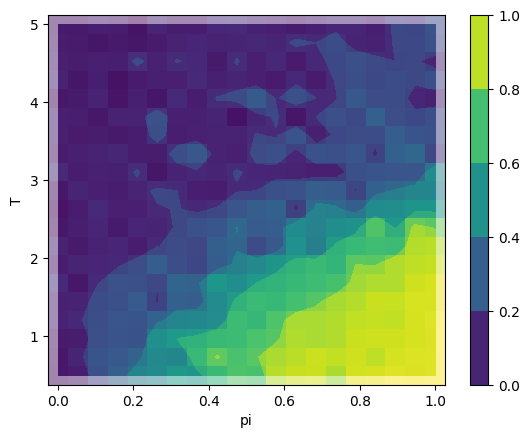

In [99]:
plt.contourf(PIS, TS, avg_m, 5)
plt.colorbar()
plt.pcolormesh(PIS, TS, avg_m, alpha=0.5)

plt.xlabel("pi")
plt.ylabel("T")
plt.show()

(2) TODO

(3) TODO

### Problem 5: Inverse Ising model

(1) TODO

In [100]:
size, T, pi = 50, 4, 0.4
N, n_it = 500, 100

graph = gen_rgm_biased(size, pi)

In [101]:
states = np.zeros((N, size))
for n in range(N):
    state = gen_random_state(size)
    equilibirum_state = monte_carlo_simulate(graph, state, T, n_it)
    states[n, :] = equilibirum_state

In [102]:
correlations = np.zeros((size, size))
avgs = np.mean(states, axis=0)

for i in range(size):
    for j in range(i): # range(i + 1), force corr[i, i] = 0 so self edges are ignored
        for n in range(N):
            correlations[i, j] += states[n, i]*states[n, j]
        correlations[i, j] /= N
        
        correlations[i, j] -= avgs[i]*avgs[j]
        correlations[j, i]  = correlations[i, j]

pairs = []
for i in range(size):
    for j in range(i):
        pairs.append((i, j))
cor_pairs = zip([correlations[pair] for pair in pairs], pairs)
cor_pairs_sorted = reversed(sorted(cor_pairs))
pairs_sorted = [pair for cor,pair in cor_pairs_sorted]

In [103]:
n_predictions = np.arange(1, int(graph.number_of_edges()*2))
prediction_acc = np.zeros_like(n_predictions, dtype=float)

for i in range(len(n_predictions)):
    for pair in pairs_sorted[:n_predictions[i]]:
        prediction_acc[i] += float(graph.has_edge(pair[0], pair[1]))
    prediction_acc[i] = float(prediction_acc[i])/n_predictions[i]

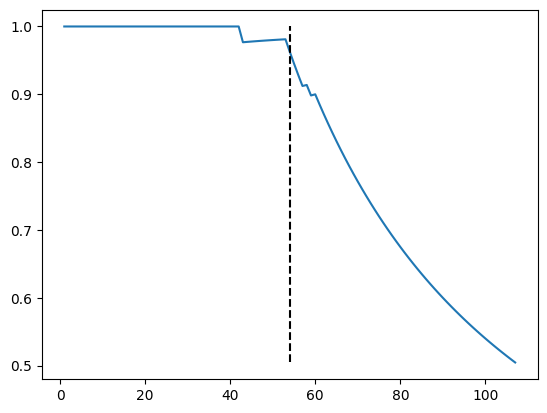

In [104]:
plt.plot(n_predictions, prediction_acc)
plt.plot([graph.number_of_edges(), graph.number_of_edges()], [min(prediction_acc), max(prediction_acc)], "k--")
plt.show()

(2) TODO

(3) TODO